<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2020_2021/blob/main/LaRanceExample/LaRance_ebb_TurbineGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as mpl
import numpy as np
%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (12, 3)

In [2]:
class Generator:

  def __init__( self ):
    self.poly_C1 = np.poly1d( np.array([-6.71448631e+03,  2.59159775e+03, 
                                        -3.80834059e+02,  2.70423225e+01, 
                                        3.29394948e-03]) )
    self.poly_C2 = np.poly1d( np.array([-1.16856952,  3.31172525, -3.44296217,  
                                        1.5416029 ,  0.71040716]) )
      
  def eta( self, load ):
    assert( load >= 0 and load <= 1.0 )
    if load < 0.125423729:
      return self.poly_C1( load ) 
    else:
      return self.poly_C2( load ) 

In [3]:
class Turbine:

  def __init__( self ):
    self.poly_CQ1 = np.poly1d( np.array([0.16928201, 0.08989368]) )
    self.poly_CQ2 = np.poly1d( np.array([-3.63920467e-04,  9.37677378e-03, 
                                         -9.25873626e-02,  1.75687197e+00]) )

    self.poly_CE1 = np.poly1d( np.array([-0.02076456, 0.20238444, 0.48984553]) )
    self.poly_CE2 = np.poly1d( np.array([-2.75685709e-04,  2.04822984e-03,  
                                         6.86081825e-04,  7.93083108e-01]) )

  def Q11( self, n11 ):
    assert( n11 >= 4.38 and n11 <= 17.17 )
    if n11 < 7.92193025936073:
      return self.poly_CQ1( n11 ) 
    else:
      return self.poly_CQ2( n11 )

  def eta( self, n11 ):
    assert( n11 >= 4.38 and n11 <= 17.17 )
    if n11 < 7.92193025936073:
      return self.poly_CE1( n11 ) 
    else:
      return self.poly_CE2( n11 )

In [4]:
π = np.pi
two_π = 2.0 * π
ga = 9.8 # gravity aceleration
ρw = 1025.0 # water density

"La Rance" data

In [47]:
S_bas = 22.0 * 1000.0**2 # basin area [m^2]
n_turbs = 24 # number of turbines
n_gates = 6  # number of sluice gates
G_ε = 2025.0 # ( n_gates * Q_sluices + n_turbs * Q_turb ) / sqrt( 2g H_rated)
D_turb = 5.35
CT1 = D_turb**2 * np.sqrt( ga )
CT2 = ρw * D_turb**2 * ga**1.5

In [48]:
ζ_tid = 4.75 # tide amplitude

In [49]:
A_gates = 10*15 * n_gates # Sluice gates area
A_turbs = π*(D_turb/2)**2 * n_turbs # Turbines area

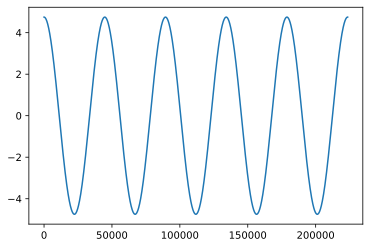

In [50]:
Per = 12.0*3600.0 + 25.2*60.0
kp = 5 # number of periods

# time points
t_vec  = np.linspace( 0.0, kp*Per, kp*300 )
delta_t = t_vec[1]

# the tidel level
y_vec = ζ_tid * np.cos( two_π * t_vec / Per )

mpl.plot( t_vec, y_vec );

Power = 4.66 MW
Max P(t) = 18.82 MW
Cap factor = 0.25


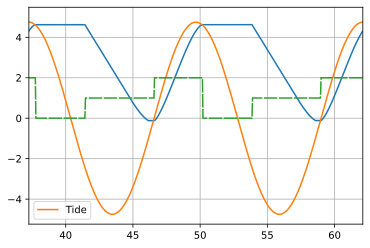

In [51]:
Turb = Turbine()
Omega = 93.75 * π / 30.0

# initial control stage
u = 0 
u_vec = np.zeros( t_vec.size ) # stores the control stage

# instantaneous power
P_vec = np.zeros( t_vec.size )

# volume vector
V_vec = np.zeros( t_vec.size )

# flow rate vector
Q_vec = np.zeros( t_vec.size )

# initial condition
V_vec[0] = S_bas * 5.0#y_vec[0]

# minimum h for turbine starting
h_min = 7

for i, t in enumerate( t_vec[:-1] ): 
  z0 = V_vec[i] / S_bas 
  h = z0 - y_vec[i]
  
  #__STAGE 0_________________________
  if u == 0:
    if h > 0.0 and h > h_min: 
      u = 1
      n11 = Omega * D_turb / np.sqrt( ga * h )
      Q = n_turbs * CT1 * Turb.Q11( n11 ) * np.sqrt( h )
      E = 0.0
    else:
      Q = 0.0
  
  #__STAGE 1_________________________
  elif u == 1:
    if h <= 0.0:
      Q = 0.0
      u = 2
    else:
      n11 = Omega * D_turb / np.sqrt( ga * h )
      if n11 <= 17.17:
        Q = n_turbs * CT1 * Turb.Q11( n11 ) * np.sqrt( h )
      else:
        Q = 0.0
  #__STAGE 2_________________________
  elif u == 2:
    if h >= 0.0:
      Q = 0.0
      u = 0
    else:
      Q = -G_ε*np.sqrt( 2.0*ga*np.abs(h) )
      
  #__________________________________
  if u == 1:
    n11 = Omega * D_turb / np.sqrt( ga * h )
    if n11 <= 17.17:
        Q = n_turbs * CT1 * Turb.Q11( n11 ) * np.sqrt( h )
        η = Turb.eta( n11 )
        P_vec[i+1] = η * ρw * ga * h * Q
      
  u_vec[i+1] = u
  V_vec[i+1] = V_vec[i] - delta_t * Q

P_avg = np.mean(P_vec) / 1E6
P_max = np.max( P_vec) / 1E6
C_fac = P_avg / P_max

print( "Power = %.2f MW" % P_avg ) 
print( "Max P(t) = %.2f MW" % P_max ) 
print( "Cap factor = %.2f" % C_fac ) 

mpl.plot( t_vec/3600, V_vec/S_bas )
mpl.plot( t_vec/3600, y_vec, label='Tide' )
mpl.plot( t_vec/3600, u_vec, dashes=(9,1) )
mpl.legend()
mpl.grid()
mpl.xlim( 3*Per/3600, 5*Per/3600 );

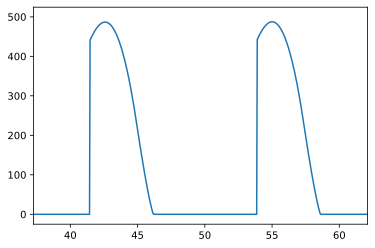

In [45]:
mpl.plot( t_vec/3600, P_vec/1e6 )
mpl.xlim( 3*Per/3600, 5*Per/3600 );